# Preperations

## Installs

In [ ]:
pip install facenet-pytorch image-reward clip ultralytics supervision

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0

## Imports

In [ ]:
from PIL import Image
import torch
import numpy as np
import prep_utils
import inference_utils
import eval_utils
import pandas as pd
from google.colab import userdata, drive, files
import os
import random
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# from eval_utils import calc_clip_embeddings, calc_clip_score, calc_dino_score, calc_dino_embeddings
# from pick_score import PickScore
# from identity_preservation import IdentityPreservation
# from image_reward import ImageReward
# from identity_stability import IdentityStability
# from aesthetic_predictor import AestheticPredictor

In [ ]:
del sys.modules['eval_utils']
del sys.modules['pick_score']
# del sys.modules['aesthetic_predictor']
# del sys.modules['clip']

# del sys.modules['inference_utils']

In [ ]:
!wget -q https://raw.githubusercontent.com/adobe/SimpleSensor/refs/heads/master/simplesensor/collection_modules/demographic_camera/classifiers/haarcascades/haarcascade_fullbody.xml
!wget -q https://raw.githubusercontent.com/adobe/SimpleSensor/refs/heads/master/simplesensor/collection_modules/demographic_camera/classifiers/haarcascades/haarcascade_upperbody.xml
!wget -q https://raw.githubusercontent.com/adobe/SimpleSensor/refs/heads/master/simplesensor/collection_modules/demographic_camera/classifiers/haarcascades/haarcascade_frontalface_default.xml

## Setup environment

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
drive.mount('/content/drive') # access google drive

Mounted at /content/drive


In [ ]:
os.environ['HF_TOKEN']= userdata.get('Huggingface')

In [ ]:
base_dir = '/content/drive/MyDrive/training_images' # path to all training images in google drive
models_parent_dir= '/content/drive/My Drive/results' # models dir setzen
# os.environ['MODELS_PARENT_DIR'] = models_parent_dir

inference_dir = '/content/drive/My Drive/inference'
# inference_dir = "/content/test"
sd15_methods = ['lora', 'dlora','textinv', 'dbooth']
# sd15_methods = ['dbooth','dlora']
sdxl_methods = ['lora','dlora','textinv']
flux_methods = ['lora']
subject_list = ['christoph', 'celine', 'timh', 'timk', 'leander', 'patrick', 'hannah', 'jannik', 'marco', 'nils']
# subject_list = ['hannah', 'celine']

In [ ]:
main_prompts = inference_utils.prompts

textinv_prompts = inference_utils.textinv_prompts

# Evaluation

## SD 1.5 Evaluation

In [ ]:
# Initialize an empty dictionary to store the scores
scores = {}
detection_infos = {}

In [ ]:
# Loop through subjects and methods
for subject in subject_list:
    train_images = prep_utils.load_images(base_dir, subject)
    train_images = [img.convert('RGB') for img in train_images]

    aux_images_path= os.path.join(os.path.join(os.path.join(base_dir), subject), "unused")
    aux_images = eval_utils.load_aux_images(aux_images_path)
    aux_images = [img.convert('RGB') for img in aux_images]

    for method in sd15_methods:

        gen_images_path = os.path.join(os.path.join(inference_dir, f"{method}/SDv1.5"), subject)
        gen_images = eval_utils.load_inference_images(gen_images_path)

        # Calculate the score
        if method == 'textinv':
            gendered_prompts = inference_utils.insert_string(prompts=textinv_prompts, subject=subject, method=method)
            pickscore = eval_utils.calc_pickscore(gendered_prompts, gen_images)
            imagereward = eval_utils.calc_image_reward_score(gendered_prompts, gen_images)

        else:
            gendered_prompts = inference_utils.insert_string(prompts=main_prompts, subject=subject, method=method)
            pickscore = eval_utils.calc_pickscore(gendered_prompts, gen_images)
            imagereward = eval_utils.calc_image_reward_score(gendered_prompts, gen_images)

        clipi = eval_utils.calc_clipi(train_images, gen_images)
        dino = eval_utils.calc_dino(train_images, gen_images)
        ips = eval_utils.calc_ips(train_images, gen_images)
        sis = eval_utils.calc_sis(aux_images, gen_images)
        aes = eval_utils.calc_aes(gen_images)
        print(subject)
        print(method)
        yolo_subject_preservation = eval_utils.calc_yolo_subject_preservation(train_images, gen_images)
        haar_subject_preservation, real_detection_info, gen_detection_info = eval_utils.calc_haar_subject_preservation(train_images, gen_images)

        # Store the scores in the dictionary
        scores[(subject, method)] = {'PickScore': pickscore, 'Clip-I': clipi, 'DINO': dino, 'AestheticScore':aes, 'IPS':ips, 'SIS':sis, 'ImageRewardScore':imagereward, 'YOLOSubjectPreservation':yolo_subject_preservation, 'HAARSubjectPreservation':haar_subject_preservation}
        detection_infos[(subject, method)] = {'RealDetection': real_detection_info, 'GenDetection': gen_detection_info}


# Convert the dictionary to a pandas DataFrame for easy table creation
df = pd.DataFrame([{**{'Subject': subject, 'Method': method}, **scores[(subject, method)]} for subject, method in scores.keys()])
test_df = pd.DataFrame([{**{'Subject': subject, 'Method': method}, **detection_infos[(subject, method)]} for subject, method in detection_infos.keys()])

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(pd.DataFrame({'ImageRewardScore': [-2, 2]}))
df['ImageRewardScore'] = scaler.transform(df[['ImageRewardScore']])

In [ ]:
df.to_excel('sdv1.5_scores_main.xlsx')
test_df.to_excel('sdv1.5_detection_infos_main.xlsx')

### Evaluation Results

In [ ]:
method_mean_scores = df.groupby('Method')[['PickScore', 'Clip-I', 'DINO', 'IPS', 'SIS','AestheticScore', 'ImageRewardScore', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']].mean()
method_mean_scores.to_excel('sdv1.5_method_mean_scores.xlsx')
print(method_mean_scores)

         PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Method                                                                       
dbooth    0.211002  0.707235  0.341463  0.600344  0.566332        0.495752   
dlora     0.210257  0.688372  0.311478  0.479832  0.440530        0.502515   
lora      0.201701  0.694077  0.372410  0.494266  0.489903        0.476807   
textinv   0.201191  0.681759  0.356230  0.471429  0.471837        0.494189   

         ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  
Method                                                                       
dbooth           1.075115                 0.471291                 0.340973  
dlora            1.157714                 0.445036                 0.360360  
lora             0.933322                 0.475032                 0.331560  
textinv          0.756472                 0.466599                 0.349332  


In [ ]:
subject_mean_scores = df.groupby('Subject')[['PickScore', 'Clip-I', 'DINO', 'IPS', 'SIS','AestheticScore', 'ImageRewardScore', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']].mean()
subject_mean_scores.to_excel('sdv1.5_subject_mean_scores.xlsx')
print(subject_mean_scores)

           PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Subject                                                                        
celine      0.211803  0.767142  0.458656  0.592751  0.547220        0.478394   
christoph   0.203788  0.621464  0.304571  0.426054  0.434894        0.493286   
hannah      0.212606  0.661466  0.331421  0.470152  0.518342        0.469604   
jannik      0.207399  0.737309  0.342597  0.647363  0.636867        0.513428   
leander     0.204049  0.656974  0.318249  0.604895  0.504451        0.505188   
marco       0.206384  0.614235  0.209256  0.378470  0.315614        0.491089   
nils        0.206833  0.708832  0.371255  0.206831  0.190983        0.505371   
patrick     0.203644  0.673159  0.363470  0.650743  0.618404        0.493530   
timh        0.201673  0.717299  0.375484  0.542086  0.544850        0.480225   
timk        0.202197  0.770729  0.378993  0.595336  0.609876        0.493042   

           ImageRewardScore  YOLOSubjec

### Unweighted Ensemble Metric

In [ ]:
metrics = method_mean_scores.columns.unique().tolist()
# Calculate the unweighted average ensemble metric
method_mean_scores['ensemble_metric'] = method_mean_scores[metrics].mean(axis=1)
method_mean_scores.to_excel('sdv1.5_method_mean_scores_ensemble_metric.xlsx')
# Example output
print(method_mean_scores[metrics + ['ensemble_metric']].head())

         PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Method                                                                       
dbooth    0.211002  0.707235  0.341463  0.600344  0.566332        0.495752   
dlora     0.210257  0.688372  0.311478  0.479832  0.440530        0.502515   
lora      0.201701  0.694077  0.372410  0.494266  0.489903        0.476807   
textinv   0.201191  0.681759  0.356230  0.471429  0.471837        0.494189   

         ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  \
Method                                                                        
dbooth           1.075115                 0.471291                 0.340973   
dlora            1.157714                 0.445036                 0.360360   
lora             0.933322                 0.475032                 0.331560   
textinv          0.756472                 0.466599                 0.349332   

         ensemble_metric  
Method                    
db

In [ ]:
metrics = subject_mean_scores.columns.unique().tolist()
# Calculate the unweighted average ensemble metric
subject_mean_scores['ensemble_metric'] = subject_mean_scores[metrics].mean(axis=1)
subject_mean_scores.to_excel('sdv1.5_subject_mean_scores_ensemble_metric.xlsx')

# Example output
print(subject_mean_scores[metrics + ['ensemble_metric']].head())

           PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Subject                                                                        
celine      0.211803  0.767142  0.458656  0.592751  0.547220        0.478394   
christoph   0.203788  0.621464  0.304571  0.426054  0.434894        0.493286   
hannah      0.212606  0.661466  0.331421  0.470152  0.518342        0.469604   
jannik      0.207399  0.737309  0.342597  0.647363  0.636867        0.513428   
leander     0.204049  0.656974  0.318249  0.604895  0.504451        0.505188   

           ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  \
Subject                                                                         
celine             0.915166                 0.414962                 0.376404   
christoph          1.129352                 0.543143                 0.359635   
hannah             0.773146                 0.415007                 0.325830   
jannik             1.012661       

### Additional HAAR Cascade Subject Preservation Evaluation

In [ ]:
expected_values = ['body', 'face', 'upper body', 'nothing']

In [ ]:
real_detection_df = test_df.copy()
real_detection_df = real_detection_df.explode('RealDetection')

gen_detection_df = test_df.copy()
gen_detection_df = gen_detection_df.explode('GenDetection')


real_detection_df = real_detection_df['RealDetection'].apply(pd.Series)
real_detection_df = real_detection_df.add_suffix('_Real')

gen_detection_df = gen_detection_df['GenDetection'].apply(pd.Series)
gen_detection_df = gen_detection_df.add_suffix('_Gen')

real_detection_df = pd.concat([test_df[['Subject', 'Method']], real_detection_df], axis=1)
gen_detection_df = pd.concat([test_df[['Subject', 'Method']], gen_detection_df], axis=1)

In [ ]:
# Create the pivot table
counts = pd.pivot_table(real_detection_df, index='Subject', columns=['detection_Real'], aggfunc='size', fill_value=0)

# Reindex the columns to include all expected values, filling missing ones with 0
counts = counts.reindex(columns=expected_values, fill_value=0)
counts.to_excel('sdv1.5_haar_detections_training_images.xlsx')

print(counts)

detection_Real  body  face  upper body  nothing
Subject                                        
celine            16     8          16        0
christoph         28     4           8        0
hannah            24     0          16        0
jannik            12     8          20        0
leander           16     8          16        0
marco             32     0           8        0
nils              28     8           4        0
patrick           32     4           4        0
timh              28     4           8        0
timk              28     4           8        0


In [ ]:
#automatic charts here?

In [ ]:
# Create the pivot table
counts = pd.pivot_table(gen_detection_df, index='Method', columns=['Subject', 'detection_Gen'], aggfunc='size', fill_value=0)

# Get all possible combinations of Subject and detection_Gen
subjects = gen_detection_df['Subject'].unique()
detection_gens = gen_detection_df['detection_Gen'].unique()
all_combinations = pd.MultiIndex.from_product([subjects, detection_gens], names=['Subject', 'detection_Gen'])

# Reindex the pivot table to include all combinations
counts = counts.reindex(columns=all_combinations, fill_value=0)
counts.to_excel('sdv1.5_haar_detections_generated_images.xlsx')

print(counts)

Subject       christoph                       celine                       \
detection_Gen   nothing face upper body body nothing face upper body body   
Method                                                                      
dbooth                1    8          1    0       0    6          3    1   
dlora                 1    6          2    1       0    5          2    3   
lora                  3    5          2    0       1    5          2    2   
textinv               0    4          4    2       0    7          3    0   

Subject          timh       ...     jannik        marco                       \
detection_Gen nothing face  ... upper body body nothing face upper body body   
Method                      ...                                                
dbooth              1    5  ...          2    2       0    2          6    2   
dlora               0    7  ...          2    1       0    5          5    0   
lora                1    4  ...          2    2       0    6

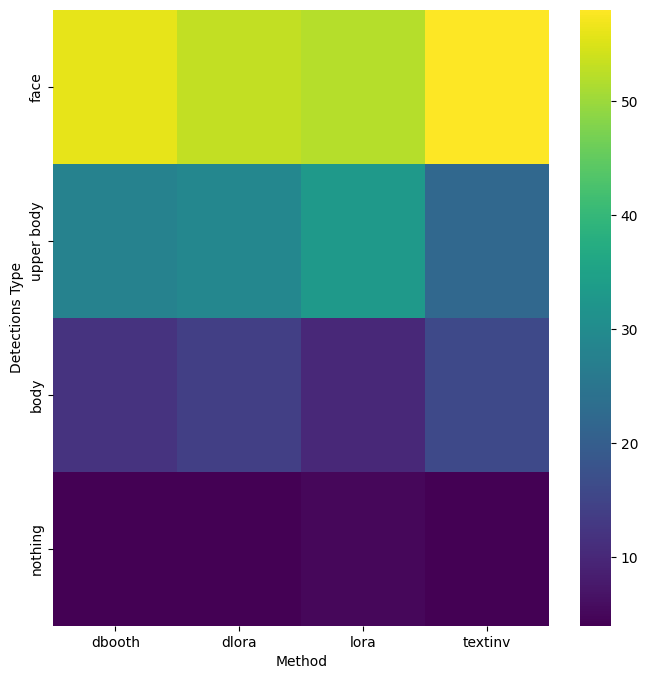

In [ ]:
# @title Detections in Generated Images vs. Training Techniques

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['detection_Gen'].value_counts()
    for x_label, grp in gen_detection_df.groupby('Method')
})
heatmap = sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Method')
_ = plt.ylabel('Detections Type')

fig = heatmap.get_figure()
fig.savefig("sd1.5_gen_detections_method_heatmap.png")



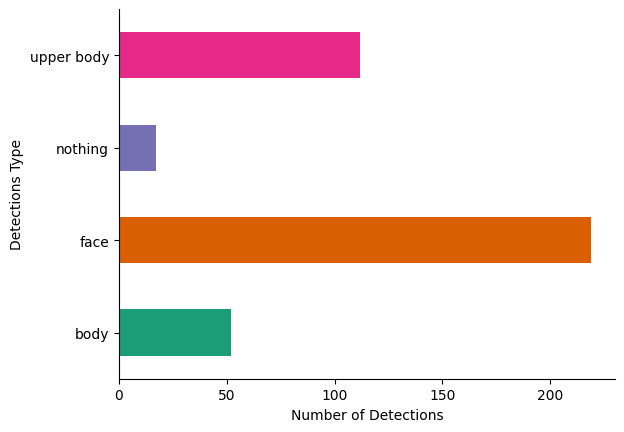

In [ ]:
# @title Detections in Generated Images

from matplotlib import pyplot as plt
import seaborn as sns
gen_detection_df.groupby('detection_Gen').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Number of Detections')
_ = plt.ylabel('Detections Type')
plt.savefig("sd1.5_gen_detections_numbers.png")

## SDXL Evaluation

In [ ]:
# Initialize an empty dictionary to store the scores
scores = {}
detection_infos = {}

In [ ]:
# Loop through subjects and methods
for subject in subject_list:
    train_images = prep_utils.load_images(base_dir, subject)
    train_images = [img.convert('RGB') for img in train_images]

    aux_images_path= os.path.join(os.path.join(os.path.join(base_dir), subject), "unused")
    aux_images = eval_utils.load_aux_images(aux_images_path)
    aux_images = [img.convert('RGB') for img in aux_images]

    for method in sdxl_methods:

        gen_images_path = os.path.join(os.path.join(inference_dir, f"{method}/SDXL"), subject)
        gen_images = eval_utils.load_inference_images(gen_images_path)

        # Calculate the score
        if method == 'textinv':
            gendered_prompts = inference_utils.insert_string(prompts=textinv_prompts, subject=subject, method=method)
            pickscore = eval_utils.calc_pickscore(gendered_prompts, gen_images)
            imagereward = eval_utils.calc_image_reward_score(gendered_prompts, gen_images)

        else:
            gendered_prompts = inference_utils.insert_string(prompts=main_prompts, subject=subject, method=method)
            pickscore = eval_utils.calc_pickscore(gendered_prompts, gen_images)
            imagereward = eval_utils.calc_image_reward_score(gendered_prompts, gen_images)

        clipi = eval_utils.calc_clipi(train_images, gen_images)
        dino = eval_utils.calc_dino(train_images, gen_images)
        ips = eval_utils.calc_ips(train_images, gen_images)
        sis = eval_utils.calc_sis(aux_images, gen_images)
        aes = eval_utils.calc_aes(gen_images)
        print(subject)
        print(method)
        yolo_subject_preservation = eval_utils.calc_yolo_subject_preservation(train_images, gen_images)
        haar_subject_preservation, real_detection_info, gen_detection_info = eval_utils.calc_haar_subject_preservation(train_images, gen_images)

        # Store the scores in the dictionary
        scores[(subject, method)] = {'PickScore': pickscore, 'Clip-I': clipi, 'DINO': dino, 'AestheticScore':aes, 'IPS':ips, 'SIS':sis, 'ImageRewardScore':imagereward, 'YOLOSubjectPreservation':yolo_subject_preservation, 'HAARSubjectPreservation':haar_subject_preservation}
        detection_infos[(subject, method)] = {'RealDetection': real_detection_info, 'GenDetection': gen_detection_info}


# Convert the dictionary to a pandas DataFrame for easy table creation
df = pd.DataFrame([{**{'Subject': subject, 'Method': method}, **scores[(subject, method)]} for subject, method in scores.keys()])
test_df = pd.DataFrame([{**{'Subject': subject, 'Method': method}, **detection_infos[(subject, method)]} for subject, method in detection_infos.keys()])


Shape of image_embs: torch.Size([10, 1024])
Shape of text_embs: torch.Size([10, 1024])


ImageReward.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

load checkpoint from /root/.cache/ImageReward/ImageReward.pt


med_config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

checkpoint loaded


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

  0%|          | 0.00/107M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

christoph
lora


100%|██████████| 109M/109M [00:00<00:00, 349MB/s]



0: 640x640 1 person, 26.6ms
1: 640x640 1 person, 26.6ms
2: 640x640 1 person, 26.6ms
3: 640x640 1 person, 1 umbrella, 26.6ms
4: 640x640 2 persons, 26.6ms
5: 640x640 1 person, 2 forks, 2 knifes, 1 spoon, 1 couch, 1 dining table, 26.6ms
6: 640x640 2 persons, 26.6ms
7: 640x640 1 person, 26.6ms
8: 640x640 1 person, 1 tie, 26.6ms
9: 640x640 1 person, 2 clocks, 26.6ms
Speed: 3.6ms preprocess, 26.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 tie, 20.0ms
1: 640x640 1 person, 1 car, 1 tie, 1 chair, 20.0ms
2: 640x640 1 person, 1 tie, 20.0ms
3: 640x640 4 persons, 1 tie, 20.0ms
4: 640x640 2 persons, 1 potted plant, 20.0ms
5: 640x640 1 person, 1 tie, 20.0ms
6: 640x640 2 persons, 1 potted plant, 1 clock, 20.0ms
7: 640x640 1 person, 1 tie, 20.0ms
8: 640x640 1 person, 1 tie, 20.0ms
9: 640x640 1 person, 1 tie, 20.0ms
Speed: 3.7ms preprocess, 20.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Shape of image_embs: torch.Size([10, 1024])
Shape of text_embs: torch.Size([10, 1024])
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
christoph
dlora

0: 640x640 1 person, 20.3ms
1: 640x640 1 person, 20.3ms
2: 640x640 1 person, 20.3ms
3: 640x640 1 person, 1 umbrella, 20.3ms
4: 640x640 2 persons, 20.3ms
5: 640x640 1 person, 2 forks, 2 knifes, 1 spoon, 1 couch, 1 dining table, 20.3ms
6: 640x640 2 persons, 20.3ms
7: 640x640 1 person, 20.3ms
8: 640x640 1 person, 1 tie, 20.3ms
9: 640x640 1 person, 2 clocks, 20.3ms
Speed: 2.8ms preprocess, 20.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 tie, 19.9ms
1: 640x640 1 person, 1 tie, 19.9ms
2: 640x640 1 person, 19.9ms
3: 640x640 1 person, 2 chairs, 1 dining table, 19.9ms
4: 640x640 1 person, 2 chairs, 1 tv, 2 mouses, 1 keyboard, 1 clock, 19.9ms
5: 640x640 1 person, 1 tie, 19.9ms
6: 640x640 1 person, 19.9ms
7: 640x640 1 person, 1 tie, 19.9ms
8: 640x640 1 person, 19.9ms
9:

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(pd.DataFrame({'ImageRewardScore': [-2, 2]}))
df['ImageRewardScore'] = scaler.transform(df[['ImageRewardScore']])


In [ ]:
df.to_excel('sdxl_scores_main.xlsx')
test_df.to_excel('sdxl_detection_infos_main.xlsx')

### Evaluation Results

In [ ]:
method_mean_scores = df.groupby('Method')[['PickScore', 'Clip-I', 'DINO', 'IPS', 'SIS','AestheticScore', 'ImageRewardScore', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']].mean()
method_mean_scores.to_excel('sdxl_method_mean_scores.xlsx')
print(method_mean_scores)

         PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Method                                                                       
dlora     0.215643  0.717450  0.344923  0.710161  0.681983        0.505420   
lora      0.214812  0.731384  0.354940  0.753416  0.727458        0.506934   
textinv   0.208919  0.720380  0.369007  0.383036  0.403531        0.477539   

         ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  
Method                                                                       
dlora            1.543350                 0.462069                 0.397224  
lora             1.556457                 0.456986                 0.404748  
textinv          1.044728                 0.473155                 0.392871  


In [ ]:
subject_mean_scores = df.groupby('Subject')[['PickScore', 'Clip-I', 'DINO', 'IPS', 'SIS','AestheticScore', 'ImageRewardScore', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']].mean()
subject_mean_scores.to_excel('sdxl_subject_mean_scores.xlsx')
print(subject_mean_scores)

           PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Subject                                                                        
celine      0.222220  0.794385  0.433087  0.675383  0.672367        0.472087   
christoph   0.212229  0.657654  0.343842  0.650832  0.644164        0.512695   
hannah      0.217544  0.680968  0.370825  0.599910  0.618985        0.464518   
jannik      0.216093  0.763514  0.333588  0.681807  0.623781        0.517090   
leander     0.214478  0.705173  0.336742  0.736665  0.707491        0.504232   
marco       0.213093  0.636475  0.203551  0.517636  0.424522        0.475260   
nils        0.208502  0.743136  0.388703  0.275499  0.328270        0.512370   
patrick     0.213113  0.686519  0.366721  0.702679  0.702481        0.516439   
timh        0.207069  0.761193  0.385271  0.622206  0.623300        0.500407   
timk        0.206906  0.801700  0.400568  0.692760  0.697880        0.491211   

           ImageRewardScore  YOLOSubjec

### Unweighted Ensemble Metric

In [ ]:
metrics = method_mean_scores.columns.unique().tolist()
# Calculate the unweighted average ensemble metric
method_mean_scores['ensemble_metric'] = method_mean_scores[metrics].mean(axis=1)
method_mean_scores.to_excel('sdxl_method_mean_scores_ensemble_metric.xlsx')
# Example output
print(method_mean_scores[metrics + ['ensemble_metric']].head())

         PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Method                                                                       
dlora     0.215643  0.717450  0.344923  0.710161  0.681983        0.505420   
lora      0.214812  0.731384  0.354940  0.753416  0.727458        0.506934   
textinv   0.208919  0.720380  0.369007  0.383036  0.403531        0.477539   

         ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  \
Method                                                                        
dlora            1.543350                 0.462069                 0.397224   
lora             1.556457                 0.456986                 0.404748   
textinv          1.044728                 0.473155                 0.392871   

         ensemble_metric  
Method                    
dlora           0.619803  
lora            0.634126  
textinv         0.497019  


In [ ]:
metrics = subject_mean_scores.columns.unique().tolist()
# Calculate the unweighted average ensemble metric
subject_mean_scores['ensemble_metric'] = subject_mean_scores[metrics].mean(axis=1)
subject_mean_scores.to_excel('sdxl_subject_mean_scores_ensemble_metric.xlsx')

# Example output
print(subject_mean_scores[metrics + ['ensemble_metric']].head())

           PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Subject                                                                        
celine      0.222220  0.794385  0.433087  0.675383  0.672367        0.472087   
christoph   0.212229  0.657654  0.343842  0.650832  0.644164        0.512695   
hannah      0.217544  0.680968  0.370825  0.599910  0.618985        0.464518   
jannik      0.216093  0.763514  0.333588  0.681807  0.623781        0.517090   
leander     0.214478  0.705173  0.336742  0.736665  0.707491        0.504232   

           ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  \
Subject                                                                         
celine             1.313063                 0.424439                 0.433992   
christoph          1.290898                 0.546568                 0.451628   
hannah             1.197632                 0.348147                 0.345604   
jannik             1.543319       

### Additional HAAR Cascade Subject Preservation Evaluation

In [ ]:
expected_values = ['body', 'face', 'upper body', 'nothing']

In [ ]:
real_detection_df = test_df.copy()
real_detection_df = real_detection_df.explode('RealDetection')

gen_detection_df = test_df.copy()
gen_detection_df = gen_detection_df.explode('GenDetection')


real_detection_df = real_detection_df['RealDetection'].apply(pd.Series)
real_detection_df = real_detection_df.add_suffix('_Real')

gen_detection_df = gen_detection_df['GenDetection'].apply(pd.Series)
gen_detection_df = gen_detection_df.add_suffix('_Gen')

real_detection_df = pd.concat([test_df[['Subject', 'Method']], real_detection_df], axis=1)
gen_detection_df = pd.concat([test_df[['Subject', 'Method']], gen_detection_df], axis=1)

In [ ]:
# Create the pivot table
counts = pd.pivot_table(real_detection_df, index='Subject', columns=['detection_Real'], aggfunc='size', fill_value=0)

# Reindex the columns to include all expected values, filling missing ones with 0
counts = counts.reindex(columns=expected_values, fill_value=0)
counts.to_excel('sdxl_haar_detections_training_images.xlsx')

print(counts)

detection_Real  body  face  upper body  nothing
Subject                                        
celine            12     6          12        0
christoph         21     3           6        0
hannah            18     0          12        0
jannik             9     6          15        0
leander           12     6          12        0
marco             24     0           6        0
nils              21     6           3        0
patrick           24     3           3        0
timh              21     3           6        0
timk              21     3           6        0


In [ ]:
#automatic charts here?

In [ ]:
# Create the pivot table
counts = pd.pivot_table(gen_detection_df, index='Method', columns=['Subject', 'detection_Gen'], aggfunc='size', fill_value=0)

# Get all possible combinations of Subject and detection_Gen
subjects = gen_detection_df['Subject'].unique()
detection_gens = gen_detection_df['detection_Gen'].unique()
all_combinations = pd.MultiIndex.from_product([subjects, detection_gens], names=['Subject', 'detection_Gen'])

# Reindex the pivot table to include all combinations
counts = counts.reindex(columns=all_combinations, fill_value=0)
counts.to_excel('sdxl_haar_detections_generated_images.xlsx')

print(counts)

Subject       christoph                 celine                 timh       \
detection_Gen      face body upper body   face body upper body face body   
Method                                                                     
dlora                 1    3          6      3    3          4    1    4   
lora                  4    3          3      1    3          6    2    7   
textinv               4    4          2      0    7          3    1    5   

Subject                  timk  ...     hannah jannik                 marco  \
detection_Gen upper body face  ... upper body   face body upper body  face   
Method                         ...                                           
dlora                  5    6  ...          4      3    4          3     4   
lora                   1    6  ...          3      5    5          0     6   
textinv                4    3  ...          1      3    1          6     5   

Subject                       nils                  
detection_Gen body up

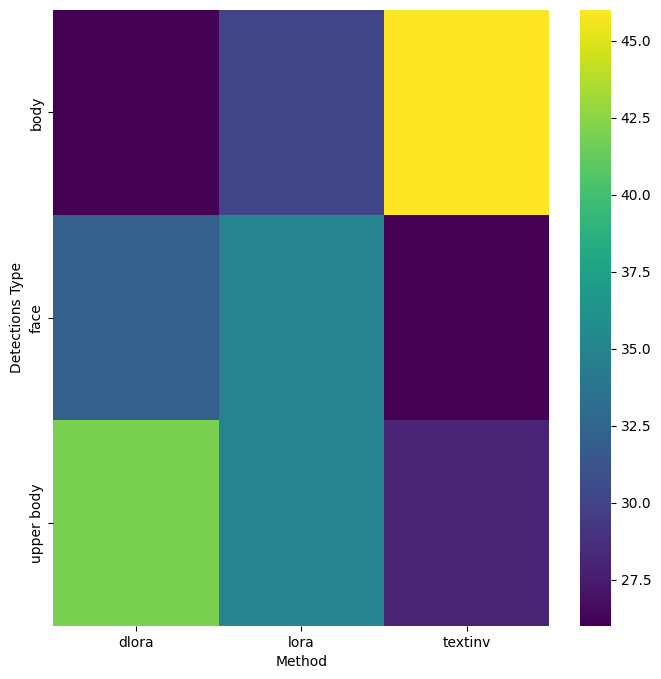

In [ ]:
# @title Detections in Generated Images vs. Training Techniques

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['detection_Gen'].value_counts()
    for x_label, grp in gen_detection_df.groupby('Method')
})
heatmap = sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Method')
_ = plt.ylabel('Detections Type')

fig = heatmap.get_figure()
fig.savefig("sdxl_gen_detections_method_heatmap.png")



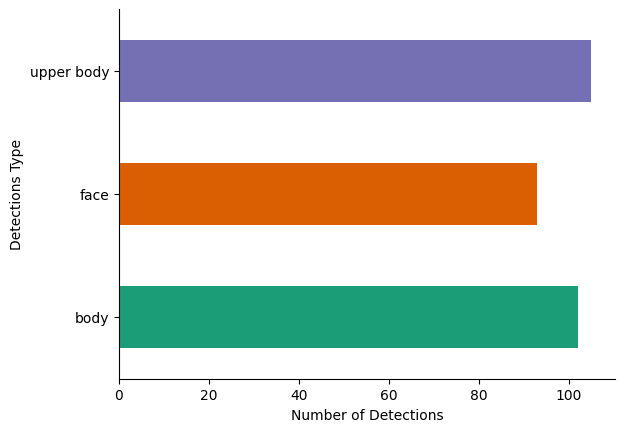

In [ ]:
# @title Detections in Generated Images

from matplotlib import pyplot as plt
import seaborn as sns
gen_detection_df.groupby('detection_Gen').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Number of Detections')
_ = plt.ylabel('Detections Type')
plt.savefig("sdxl_gen_detections_numbers.png")

## Flux Eval

In [ ]:
# Initialize an empty dictionary to store the scores
scores = {}
method = 'lora'
detection_infos = {}

In [ ]:
# Loop through subjects (only lora method)
for subject in subject_list:
    train_images = prep_utils.load_images(base_dir, subject)
    train_images = [img.convert('RGB') for img in train_images]

    aux_images_path= os.path.join(os.path.join(os.path.join(base_dir), subject), "unused")
    aux_images = eval_utils.load_aux_images(aux_images_path)
    aux_images = [img.convert('RGB') for img in aux_images]

    gen_images_path = os.path.join(os.path.join(inference_dir, f"lora/flux"), subject)
    gen_images = eval_utils.load_inference_images(gen_images_path)

    gendered_prompts = inference_utils.insert_string(prompts=main_prompts, subject=subject, method='lora')

    pickscore = eval_utils.calc_pickscore(gendered_prompts, gen_images)
    imagereward = eval_utils.calc_image_reward_score(gendered_prompts, gen_images)
    clipi = eval_utils.calc_clipi(train_images, gen_images)
    dino = eval_utils.calc_dino(train_images, gen_images)
    ips = eval_utils.calc_ips(train_images, gen_images)
    sis = eval_utils.calc_sis(aux_images, gen_images)
    aes = eval_utils.calc_aes(gen_images)
    print(subject)
    yolo_subject_preservation = eval_utils.calc_yolo_subject_preservation(train_images, gen_images)
    haar_subject_preservation, real_detection_info, gen_detection_info = eval_utils.calc_haar_subject_preservation(train_images, gen_images)

    # Store the scores in the dictionary
    scores[(subject, method)] = {'PickScore': pickscore, 'Clip-I': clipi, 'DINO': dino, 'AestheticScore':aes, 'IPS':ips, 'SIS':sis, 'ImageRewardScore':imagereward, 'YOLOSubjectPreservation':yolo_subject_preservation, 'HAARSubjectPreservation':haar_subject_preservation}
    detection_infos[(subject, method)] = {'RealDetection': real_detection_info, 'GenDetection': gen_detection_info}

# Convert the dictionary to a pandas DataFrame for easy table creation
df = pd.DataFrame([{**{'Subject': subject, 'Method': method}, **scores[(subject, method)]} for subject, method in scores.keys()])
test_df = pd.DataFrame([{**{'Subject': subject, 'Method': method}, **detection_infos[(subject, method)]} for subject, method in detection_infos.keys()])

load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
christoph

0: 640x640 1 person, 20.7ms
1: 640x640 1 person, 20.7ms
2: 640x640 1 person, 20.7ms
3: 640x640 1 person, 1 umbrella, 20.7ms
4: 640x640 2 persons, 20.7ms
5: 640x640 1 person, 2 forks, 2 knifes, 1 spoon, 1 couch, 1 dining table, 20.7ms
6: 640x640 2 persons, 20.7ms
7: 640x640 1 person, 20.7ms
8: 640x640 1 person, 1 tie, 20.7ms
9: 640x640 1 person, 2 clocks, 20.7ms
Speed: 2.7ms preprocess, 20.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 tie, 20.6ms
1: 640x640 1 person, 20.6ms
2: 640x640 1 person, 1 tie, 20.6ms
3: 640x640 1 person, 20.6ms
4: 640x640 1 person, 20.6ms
5: 640x640 1 person, 20.6ms
6: 640x640 1 person, 20.6ms
7: 640x640 1 person, 1 tie, 20.6ms
8: 640x640 1 person, 20.6ms
9: 640x640 1 person, 1 tie, 20.6ms
Speed: 2.9ms preprocess, 20.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
load checkpoint from /root/.cache/ImageRewa

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(pd.DataFrame({'ImageRewardScore': [-2, 2]}))
df['ImageRewardScore'] = scaler.transform(df[['ImageRewardScore']])

In [ ]:
df.to_excel('flux_scores_main.xlsx')
test_df.to_excel('flux_detection_infos_main.xlsx')

### Flux Evaluation Results

In [ ]:
method_mean_scores = df.groupby('Method')[['PickScore', 'Clip-I', 'DINO', 'IPS', 'SIS','AestheticScore', 'ImageRewardScore', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']].mean()
method_mean_scores.to_excel('flux_method_mean_scores.xlsx')
print(method_mean_scores)

        PickScore    Clip-I      DINO      IPS       SIS  AestheticScore  \
Method                                                                     
lora      0.22016  0.726591  0.336317  0.74316  0.711164        0.491553   

        ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  
Method                                                                      
lora            1.636977                 0.471426                 0.393446  


In [ ]:
subject_mean_scores = df.groupby('Subject')[['PickScore', 'Clip-I', 'DINO', 'IPS', 'SIS','AestheticScore', 'ImageRewardScore', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']].mean()
subject_mean_scores.to_excel('flux_subject_mean_scores.xlsx')
print(subject_mean_scores)

           PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Subject                                                                        
celine      0.218845  0.821255  0.472457  0.868500  0.860065        0.449951   
christoph   0.215805  0.661580  0.327159  0.789672  0.746476        0.505859   
hannah      0.227559  0.691450  0.352887  0.728704  0.706252        0.446533   
jannik      0.227352  0.769392  0.345888  0.855264  0.780123        0.519531   
leander     0.222424  0.685252  0.343390  0.803105  0.734359        0.499512   
marco       0.220437  0.647744  0.190264  0.667769  0.576700        0.484375   
nils        0.220760  0.725008  0.357324  0.313566  0.360528        0.514160   
patrick     0.214220  0.712505  0.377856  0.804240  0.770381        0.492188   
timh        0.218608  0.757132  0.285888  0.799882  0.803216        0.494629   
timk        0.215591  0.794589  0.310058  0.800892  0.773545        0.508789   

           ImageRewardScore  YOLOSubjec

### Unweighted Ensemble Metric

In [ ]:
metrics = method_mean_scores.columns.unique().tolist()
# Calculate the unweighted average ensemble metric
method_mean_scores['ensemble_metric'] = method_mean_scores[metrics].mean(axis=1)
method_mean_scores.to_excel('flux_method_mean_scores_ensemble_metric.xlsx')
# Example output
print(method_mean_scores[metrics + ['ensemble_metric']].head())

        PickScore    Clip-I      DINO      IPS       SIS  AestheticScore  \
Method                                                                     
lora      0.22016  0.726591  0.336317  0.74316  0.711164        0.491553   

        ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  \
Method                                                                       
lora            1.636977                 0.471426                 0.393446   

        ensemble_metric  
Method                   
lora           0.636755  


In [ ]:
metrics = subject_mean_scores.columns.unique().tolist()
# Calculate the unweighted average ensemble metric
subject_mean_scores['ensemble_metric'] = subject_mean_scores[metrics].mean(axis=1)
subject_mean_scores.to_excel('flux_subject_mean_scores_ensemble_metric.xlsx')

# Example output
print(subject_mean_scores[metrics + ['ensemble_metric']].head())

           PickScore    Clip-I      DINO       IPS       SIS  AestheticScore  \
Subject                                                                        
celine      0.218845  0.821255  0.472457  0.868500  0.860065        0.449951   
christoph   0.215805  0.661580  0.327159  0.789672  0.746476        0.505859   
hannah      0.227559  0.691450  0.352887  0.728704  0.706252        0.446533   
jannik      0.227352  0.769392  0.345888  0.855264  0.780123        0.519531   
leander     0.222424  0.685252  0.343390  0.803105  0.734359        0.499512   

           ImageRewardScore  YOLOSubjectPreservation  HAARSubjectPreservation  \
Subject                                                                         
celine             1.441383                 0.418354                 0.396264   
christoph          1.590404                 0.459010                 0.505546   
hannah             1.618206                 0.425952                 0.325691   
jannik             1.692110       

### Additional HAAR Cascade Subject Preservation Evaluation

In [ ]:
expected_values = ['body', 'face', 'upper body', 'nothing']

In [ ]:
real_detection_df = test_df.copy()
real_detection_df = real_detection_df.explode('RealDetection')

gen_detection_df = test_df.copy()
gen_detection_df = gen_detection_df.explode('GenDetection')


real_detection_df = real_detection_df['RealDetection'].apply(pd.Series)
real_detection_df = real_detection_df.add_suffix('_Real')

gen_detection_df = gen_detection_df['GenDetection'].apply(pd.Series)
gen_detection_df = gen_detection_df.add_suffix('_Gen')

real_detection_df = pd.concat([test_df[['Subject', 'Method']], real_detection_df], axis=1)
gen_detection_df = pd.concat([test_df[['Subject', 'Method']], gen_detection_df], axis=1)

In [ ]:
# Create the pivot table
counts = pd.pivot_table(real_detection_df, index='Subject', columns=['detection_Real'], aggfunc='size', fill_value=0)

# Reindex the columns to include all expected values, filling missing ones with 0
counts = counts.reindex(columns=expected_values, fill_value=0)
counts.to_excel('flux_haar_detections_training_images.xlsx')

print(counts)

detection_Real  body  face  upper body  nothing
Subject                                        
celine             4     2           4        0
christoph          7     1           2        0
hannah             6     0           4        0
jannik             3     2           5        0
leander            4     2           4        0
marco              8     0           2        0
nils               7     2           1        0
patrick            8     1           1        0
timh               7     1           2        0
timk               7     1           2        0


In [ ]:
# Create the pivot table
counts = pd.pivot_table(gen_detection_df, index='Method', columns=['Subject', 'detection_Gen'], aggfunc='size', fill_value=0)

# Get all possible combinations of Subject and detection_Gen
subjects = gen_detection_df['Subject'].unique()
detection_gens = gen_detection_df['detection_Gen'].unique()
all_combinations = pd.MultiIndex.from_product([subjects, detection_gens], names=['Subject', 'detection_Gen'])

# Reindex the pivot table to include all combinations
counts = counts.reindex(columns=all_combinations, fill_value=0)
counts.to_excel('flux_haar_detections_generated_images.xlsx')

print(counts)

Subject       christoph                 celine                 timh  \
detection_Gen      body upper body face   body upper body face body   
Method                                                                
lora                  4          4    2      2          3    5    4   

Subject                       timk  ... hannah jannik                 marco  \
detection_Gen upper body face body  ...   face   body upper body face  body   
Method                              ...                                       
lora                   2    4    7  ...      3      2          2    6     0   

Subject                       nils                  
detection_Gen upper body face body upper body face  
Method                                              
lora                   2    8    1          2    7  

[1 rows x 30 columns]


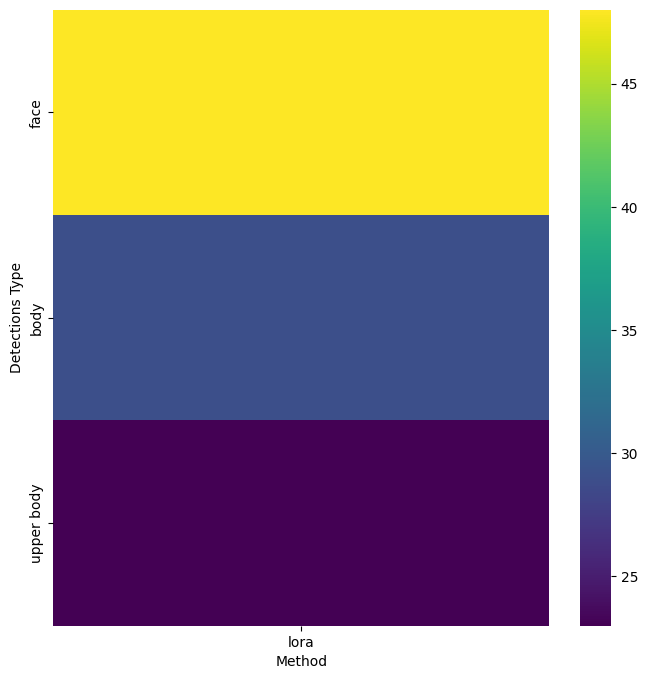

In [ ]:
# @title Detections in Generated Images vs. Training Techniques

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['detection_Gen'].value_counts()
    for x_label, grp in gen_detection_df.groupby('Method')
})
heatmap = sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Method')
_ = plt.ylabel('Detections Type')

fig = heatmap.get_figure()
fig.savefig("flux_gen_detections_method_heatmap.png")



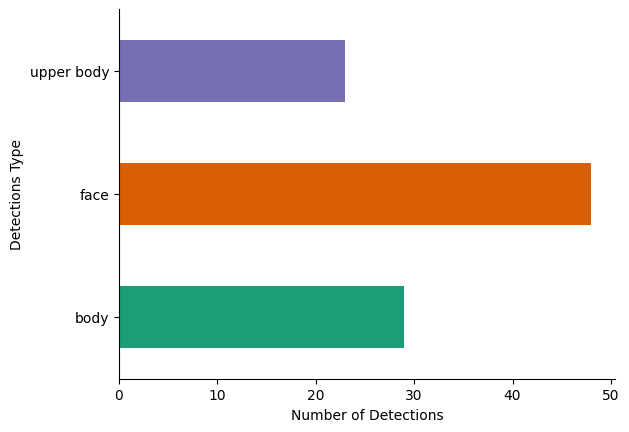

In [ ]:
# @title Detections in Generated Images

from matplotlib import pyplot as plt
import seaborn as sns
gen_detection_df.groupby('detection_Gen').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Number of Detections')
_ = plt.ylabel('Detections Type')
plt.savefig("flux_gen_detections_numbers.png")

## Descriptive Statistics

In [1]:
import pandas as pd

In [3]:
filepath1 = "/content/sd1.5_scores_main_normalizedIRS_rounded.xlsx"
filepath2 = "/content/sdxl_scores_main_normalizedIRS_rounded.xlsx"
filepath3 = "/content/flux_scores_main_normalizedIRS_rounded.xlsx"

In [4]:
def get_descriptive_stats(filepath, string):
  df = pd.read_excel(filepath, index_col=0)
  df.describe().round(3).to_excel(f"{string}_main_scores_summary.xlsx")

In [5]:
get_descriptive_stats(filepath1,'sd1.5')
get_descriptive_stats(filepath2,'sdxl')
get_descriptive_stats(filepath3,'flux')

## descriptive statistics of method and subject means

In [ ]:
import pandas as pd

In [ ]:
filepath1 = "/content/sd1.5_scores_main_normalizedIRS_rounded.xlsx"
filepath2 = "/content/sdxl_scores_main_normalizedIRS_rounded.xlsx"
filepath3 = "/content/flux_scores_main_normalizedIRS_rounded.xlsx"

# delete below probably

## scores fix

In [1]:
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
filepath1 = "/content/sd1.5_scores_main_normalizedIRS_unrounded.xlsx"
filepath2 = "/content/sdxl_scores_main_normalizedIRS_unrounded.xlsx"
filepath3 = "/content/flux_scores_main_normalizedIRS_unrounded.xlsx"

In [5]:
def fix_imagereward(filepath, string):
  # Specify the path to your Excel file

  # Use read_excel to import the Excel file into a DataFrame
  df = pd.read_excel(filepath, index_col=0)

  # scaler = MinMaxScaler(feature_range=(0, 1))
  # scaler.fit(pd.DataFrame({'ImageRewardScore': [-2, 2]}))
  # df['ImageRewardScore'] = scaler.transform(df[['ImageRewardScore']])
  df = df[['Subject', 'Method', 'PickScore', 'ImageRewardScore', 'AestheticScore', 'DINO', 'Clip-I', 'IPS', 'SIS', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']]


  method_mean_scores = df.groupby('Method')[['PickScore', 'Clip-I', 'DINO', 'IPS', 'SIS','AestheticScore', 'ImageRewardScore', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']].mean()
  method_mean_scores = method_mean_scores[['PickScore', 'ImageRewardScore', 'AestheticScore', 'DINO', 'Clip-I', 'IPS', 'SIS', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']]
  method_mean_scores.round(3).to_excel(f"{string}_method_mean_scores.xlsx")

  subject_mean_scores = df.groupby('Subject')[['PickScore', 'Clip-I', 'DINO', 'IPS', 'SIS','AestheticScore', 'ImageRewardScore', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']].mean()
  subject_mean_scores = subject_mean_scores[['PickScore', 'ImageRewardScore', 'AestheticScore', 'DINO', 'Clip-I', 'IPS', 'SIS', 'YOLOSubjectPreservation', 'HAARSubjectPreservation']]
  subject_mean_scores.round(3).to_excel(f"{string}_subject_mean_scores.xlsx")

  metrics = method_mean_scores.columns.unique().tolist()
  # Calculate the unweighted average ensemble metric
  method_mean_scores['ensemble_metric'] = method_mean_scores[metrics].mean(axis=1)
  # method_mean_scores = method_mean_scores.round({'ensemble_metric':3})
  method_mean_scores.round(3).to_excel(f"{string}_method_mean_scores_ensemble_metric.xlsx")

  metrics = subject_mean_scores.columns.unique().tolist()
  # Calculate the unweighted average ensemble metric
  subject_mean_scores['ensemble_metric'] = subject_mean_scores[metrics].mean(axis=1)
  # subject_mean_scores = subject_mean_scores.round({'ensemble_metric':3})
  subject_mean_scores.round(3).to_excel(f"{string}_subject_mean_scores_ensemble_metric.xlsx")

  df = df.round(3)
  df.to_excel(f"{string}_scores_main_normalizedIRS_rounded.xlsx")

In [6]:
fix_imagereward(filepath1,'sd1.5')
fix_imagereward(filepath2,'sdxl')
fix_imagereward(filepath3,'flux')


## test

In [ ]:
train_images = prep_utils.load_images(base_dir, 'christoph')
gen_images_path = os.path.join(os.path.join(inference_dir, f"dbooth/SDv1.5"), 'christoph')
gen_images = eval_utils.load_inference_images(gen_images_path)

In [ ]:
train_images = [img.convert('RGB') for img in train_images]


In [ ]:
from PIL import Image
img_helper = []
for img in train_images:
    img = img.convert('RGB')
    img_helper.append(img)
    # img_array = np.array(img)
    # print(img_array.shape)

In [ ]:
print(np.array(train_images[0]).shape)

(4032, 3024, 3)


In [ ]:
prt = eval_utils.calc_ips(converted_images, gen_images)

## New Subject PReservation trial (segment anything meta

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-vww2rom0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-vww2rom0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=c517f58ac5f6107618d3c7ba361ce0b6798ce8ed8adc747cf2ff08e24a6488ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-oksgaayl/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-11-05 00:07:10--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.78, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   132MB/s    in 23s     

2024-11-05 00:07:33 (107 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



## pickscore

In [ ]:
metric = PickScore(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
with open('/content/pickscore_prompts_test.txt', 'r') as file:
    prompts = file.read().splitlines()

In [ ]:
results = metric(gen_images, prompts)

In [ ]:
print(results.get('pick_score').mean())

0.18986249


## image reward score

In [ ]:
metric = ImageReward(DEVICE)

ImageReward.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

load checkpoint from /root/.cache/ImageReward/ImageReward.pt


med_config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

checkpoint loaded


In [ ]:
with open('/content/pickscore_prompts_test.txt', 'r') as file:
    prompts = file.read().splitlines()

In [ ]:
results = metric(gen_images, prompts)

In [ ]:
print(results.get('image_reward').mean())

0.7206101074814797


## Human preference score

In [ ]:
pip install hpsv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.7 MB/s eta 0:00:00
  Created wheel for clint: filename=clint-0.5.1-py3-none-any.whl size=34459 sha256=19b4bc90cdf101deb1d36ecfd2b73916d8c94517038e1b0dbe74e8954845e218
  Stored in directory: /root/.cache/pip/wheels/60/bd/a0/c20dd085251d95af656b5e3d287db7d4b4e8aec67b53a6f8dd
  Created wheel for args: filename=args-0.1.0-py3-none-any.whl size=3318 sha256=0a736d0e8fcebf3b585725ca84793619700c693080ee5ef7a3a4f057f3f1818a
  Stored in directory: /root/.cache/pip/wheels/

In [ ]:
pip install clip

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=7c49f477eaf3fb643ad37752aee7090857b8fe396ef05bb5794848f728ad955c
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip


In [ ]:
from hps import HumanPreferenceScore

In [ ]:
metric = HumanPreferenceScore(DEVICE)

AttributeError: module 'clip' has no attribute 'load'

## identity pres score

In [ ]:
metric = IdentityPreservation(DEVICE)

In [ ]:
results = metric(train_images, gen_images).mean()

In [ ]:
print(results)

0.73056346


## Identity Stability Score

In [ ]:
from identity_stability import IdentityStability

In [ ]:
metric = IdentityStability(DEVICE)

In [ ]:
results = metric(testauxset, gen_images)

In [ ]:
print(results)
print(np.array(results).mean())

[0.7802875  0.80544174 0.80264986]
0.79612637


## SIS_fast without identity_stability.py
uses single generated image combined with list of input/different images to calculate a single 1 SIS score

In [ ]:
IPS = IdentityPreservation(DEVICE)

In [ ]:
scores =[]

In [ ]:
for _testaux in testauxset:
  score = min(IPS(og_img=_testaux, syn_img=[gen_images[0]] * len(testauxset)))
  print(score)
  scores.append(score)

0.7802875
0.79703456
0.7505337


In [ ]:
print(np.array(scores).mean())

0.77595186


## SIS without identity_stability.py
requires input images that are not the input/training images --> input set of different images
calculates minimum IPS for each new different images compared with the set of generated images.
mean can be calculated from the minimum IPS values to receive the non-approximated SIS metric value.

## **you'll probably have to explain the logic behind this in your THESIS! **

In [ ]:
scores = []

In [ ]:
for _testaux, _gen_image in zip(testauxset, gen_images):
  score = min(IPS(og_img=_testaux, syn_img=[_gen_image] * len(testauxset)))
  scores.append(score)

In [ ]:
print(scores)

[0.7802875, 0.80544174, 0.80264986]


In [ ]:
print(np.array(scores).mean())

0.79612637


## subject preservation (fullbody?)
doesnt work well, because its very sensitive to what constitutes a BODY to extract embeddings from..? if theres only a head, it doesnt seem to get embeddings.. idk

In [ ]:
!wget -q https://raw.githubusercontent.com/murtazahassan/OpenCV-Python-Tutorials-and-Projects/refs/heads/master/Intermediate/Custom%20Object%20Detection/haarcascades/haarcascade_fullbody.xml

In [ ]:
!wget -q https://raw.githubusercontent.com/adobe/SimpleSensor/refs/heads/master/simplesensor/collection_modules/demographic_camera/classifiers/haarcascades/haarcascade_upperbody.xml

In [ ]:
!wget -q https://raw.githubusercontent.com/adobe/SimpleSensor/refs/heads/master/simplesensor/collection_modules/demographic_camera/classifiers/haarcascades/haarcascade_frontalface_default.xml

In [ ]:
import cv2
import torch
import torchvision.models as models
from torchvision import transforms
from torch.nn import functional as F
from scipy.spatial.distance import cosine


## idkdidk

In [ ]:


def get_embeddings(img, body_cascade, model, transform):
    """
    Extracts embeddings from a single image containing bodies.

    Args:
        img (numpy.ndarray): The image data.
        body_cascade (cv2.CascadeClassifier): Pre-trained body detection model.
        model (torch.nn.Module): Pre-trained image embedding model (e.g., ResNet50).
        transform (torchvision.transforms.Compose): Image preprocessing pipeline.

    Returns:
        list: A list of embeddings for each detected body in the image.
    """
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    bodies = body_cascade.detectMultiScale(gray)

    embeddings = None
    for (x, y, w, h) in bodies:
        cropped_img = img.crop((x, y, x + w, y + h))
        cropped_tensor = transform(cropped_img)
        cropped_tensor = cropped_tensor.unsqueeze(0)

        with torch.no_grad():
            features = model(cropped_tensor)
            embeddings = features

    return embeddings

In [ ]:
# Load pre-trained models (replace with your choices)
model = models.resnet50(pretrained=True)
model.eval()
body_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')
upper_cascade = cv2.CascadeClassifier('haarcascade_upperbody.xml')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Image preprocessing (modify as needed)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [ ]:

# Read images
img1 = train_images[1]
img2 = gen_images[4]

# Get embeddings
embeddings1 = get_embeddings(img1, body_cascade, model, transform)
embeddings2 = get_embeddings(img2, body_cascade, model, transform)


In [ ]:

# Calculate cosine similarity
# similarities = compare_embeddings(embeddings1, embeddings2)

# # Print results
# if similarities:
#     print("Pairwise cosine similarities between bodies:")
#     for i, similarity in enumerate(similarities):
#         print(f"Body {i+1} (image1) - Body {i+1} (image2): {similarity:.4f}")
# else:
#     print("No bodies detected in either image or similarity calculation failed.")

In [ ]:
metric = F.cosine_similarity(embeddings1, embeddings2, dim=1).mean()

In [ ]:
print(metric)

tensor(0.5207)


In [ ]:
for image in train_images:
    image_array = np.array(image)
    print(image_array.shape)

(3264, 1836, 3)
(3264, 1836, 3)
(1836, 3264, 3)
(3264, 1836, 3)
(1836, 3264, 3)


only detects upperbody atm. if it doesnt detect, it just continues. thus, the metric is severly affected and sensitive to undetected upperbodies, makign the metric kinda meh?
could be outputting the image files or something where it cant find upperbodies. this way context can be added to the metric. it may not be the best metric for this reason.

-> truncating the longer tensor als fix.

also: generally seems like a rather bad metric because even with upper body detection and getting the embeddings from there, as its not just considering faces, there will be ALOT of variation either way!!

In [ ]:
def calculate_body_score(real_images, gen_images):
  generated_embeddings, gen_detection_info = calculate_body_embeddings(gen_images)
  real_embeddings, real_detection_info = calculate_body_embeddings(real_images)

  # Ensure the concatenated tensors have the same shape by truncating the longer tensor
  min_length = min(generated_embeddings.shape[0], real_embeddings.shape[0])
  generated_embeddings = generated_embeddings[:min_length]
  real_embeddings = real_embeddings[:min_length]

  metric = F.cosine_similarity(generated_embeddings, real_embeddings, dim=1).mean()
  return float(metric), real_detection_info, gen_detection_info


In [ ]:
def calculate_body_embeddings(images):
  # Image preprocessing (modify as needed)
  transform = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  ])

  # Load pre-trained models (replace with your choices)
  model = models.resnet50(pretrained=True)
  model.eval()
  # body_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')
  body_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')
  upper_cascade = cv2.CascadeClassifier('haarcascade_upperbody.xml')
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

  bodies = []
  upper_bodies = []
  faces = []
  cropped_images = []
  image_features = []
  images_with_no_body = []
  detection_info = []


  for i, image in enumerate(images):
      # Convert the image to a NumPy array
      image_array = np.array(image)

      # Detect bodies in the image
      body = body_cascade.detectMultiScale(image_array, scaleFactor=1.05, minNeighbors=3, minSize=(20, 20))
      upper_body = upper_cascade.detectMultiScale(image_array, scaleFactor=1.05, minNeighbors=3, minSize=(20, 20))
      face = face_cascade.detectMultiScale(image_array, scaleFactor=1.05, minNeighbors=3, minSize=(20, 20))

      # Check if any bodies were detected
      if body is not None and len(body) > 0:
          x, y, w, h = body[0]
          cropped_image = transform(image.crop((x, y, x + w, y + h))).unsqueeze(0)
          cropped_images.append(cropped_image)
          bodies.append(body[0])
          detection_info.append({"image_index": i, "detection": "body"})
      elif upper_body is not None and len(upper_body) > 0:
          x, y, w, h = upper_body[0]
          cropped_image = transform(image.crop((x, y, x + w, y + h))).unsqueeze(0)
          cropped_images.append(cropped_image)
          upper_bodies.append(upper_body[0])
          detection_info.append({"image_index": i, "detection": "upper body"})
      elif face is not None and len(face) > 0:
          x, y, w, h = face[0]
          cropped_image = transform(image.crop((x, y, x + w, y + h))).unsqueeze(0)
          cropped_images.append(cropped_image)
          faces.append(face[0])
          detection_info.append({"image_index": i, "detection": "face"})
      else:
          images_with_no_body.append(image)
          detection_info.append({"image_index": i, "detection": "nothing"})

  # Process the cropped images to get features
  for cropped_image in cropped_images:
        with torch.no_grad():
            image_features.append(model(cropped_image))

  # Concatenate the list of tensors into a single tensor along the batch dimension (dim=0)
  if image_features:
      image_features = torch.cat(image_features, dim=0)
  else:
      image_features = torch.tensor([])  # Return an empty tensor if no features are found


  return image_features, detection_info

In [ ]:
train_images = prep_utils.load_images(base_dir, 'hannah')
gen_images_path = os.path.join(os.path.join(inference_dir, f"dbooth/SDv1.5"), 'hannah')
gen_images = eval_utils.load_inference_images(gen_images_path)


In [ ]:
helper, real_detection_info, gen_detection_info = calculate_body_score(train_images, gen_images)

In [ ]:
helper

0.39057403802871704

In [ ]:
real_detection_info

[{'image_index': 0, 'detection': 'body'},
 {'image_index': 1, 'detection': 'body'},
 {'image_index': 2, 'detection': 'upper body'},
 {'image_index': 3, 'detection': 'upper body'},
 {'image_index': 4, 'detection': 'body'},
 {'image_index': 5, 'detection': 'upper body'},
 {'image_index': 6, 'detection': 'body'},
 {'image_index': 7, 'detection': 'body'},
 {'image_index': 8, 'detection': 'body'},
 {'image_index': 9, 'detection': 'upper body'}]

In [ ]:
gen_detection_info

[{'image_index': 0, 'detection': 'face'},
 {'image_index': 1, 'detection': 'face'},
 {'image_index': 2, 'detection': 'face'},
 {'image_index': 3, 'detection': 'upper body'},
 {'image_index': 4, 'detection': 'face'},
 {'image_index': 5, 'detection': 'upper body'},
 {'image_index': 6, 'detection': 'face'},
 {'image_index': 7, 'detection': 'body'},
 {'image_index': 8, 'detection': 'face'},
 {'image_index': 9, 'detection': 'nothing'}]

## detectron trial idk

In [ ]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-yxd5e2d6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-yxd5e2d6
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done


In [ ]:
# import detectron2.data.detection as dd
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.engine.defaults import DefaultPredictor

def calculate_body_embeddings(images):
    # ... (rest of your image preprocessing)

    # Load pre-trained Detectron2 model
    cfg = get_cfg()
    cfg.merge_from_file("/content/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.WEIGHTS = "detectron2/model_zoo/COCO-InstanceSegmentation/maskrcnn_R_50_FPN_3x_13728040_e67e80.pth"  # Replace with your desired model
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set to 1 for single-class (human) detection
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    predictor = DefaultPredictor(cfg)

    embeddings = []
    for image in images:
        # Detect bodies using Detectron2
        outputs = predictor(image)
        instances = outputs["instances"]

        # Extract bounding boxes
        boxes = instances.pred_boxes.tensor.tolist()

        for bbox in boxes:
            x1, y1, x2, y2 = bbox
            cropped_image = image.crop((x1, y1, x2, y2))
            cropped_tensor = transform(cropped_image).unsqueeze(0)

            with torch.no_grad():
                image_feature = model(cropped_tensor)
            embeddings.append(image_feature)

    return embeddings

In [ ]:
def calculate_body_score(real_images, gen_images):
  generated_embeddings = calculate_body_embeddings(gen_images)
  real_embeddings = calculate_body_embeddings(train_images)
  metric = F.cosine_similarity(generated_embeddings, real_embeddings, dim=1).mean()
  return float(metric)

In [ ]:
!python -m detectron2.utils.download_model_zoo

/usr/bin/python3: No module named detectron2.utils.download_model_zoo


In [ ]:
!python -c "import detectron2"

In [ ]:
!find detectron2/model_zoo -name "maskrcnn_R_50_FPN_3x.yaml"

find: ‘detectron2/model_zoo’: No such file or directory


In [ ]:
!wget -q https://raw.githubusercontent.com/facebookresearch/detectron2/refs/heads/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml

In [ ]:
!wget -q https://raw.githubusercontent.com/facebookresearch/detectron2/refs/heads/main/configs/Base-RCNN-FPN.yaml

In [ ]:
helper = calculate_body_score(train_images, gen_images)

FileNotFoundError: [Errno 2] No such file or directory: '/Base-RCNN-FPN.yaml'

False

## idk dino2

In [ ]:
test = calc_dino_score(train_images,gen_images)
test

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.2801371216773987

In [ ]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests
from torch.nn import functional as F
import torch

def calc_dino2_score(training_images, generated_images):
  # Calculate embeddings for both sets
  generated_embeddings = calc_dino_embeddings(generated_images)
  real_embeddings = calc_dino_embeddings(training_images)
  metric = F.cosine_similarity(generated_embeddings, real_embeddings, dim=1).mean()
  return float(metric)

# Function to calculate embeddings
def calc_dino2_embeddings(images):
    # Define transformations
    # Define model
    processor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
    model = ViTModel.from_pretrained('facebook/dino-vits16')
    with torch.no_grad():
        inputs = processor(images=images, return_tensors="pt")
        outputs = model(inputs)
        last_hidden_states = outputs.last_hidden_state  # ViT backbone features

    return last_hidden_states[:, 0]  # Get cls token (0-th token) for each img

In [ ]:
wowo = calc_dino2_score(train_images, gen_images)
wowo

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.2801371216773987

In [ ]:
## ungleiche image sets implementierung below!!

# import torch
# import torch.nn.functional as F

# def calc_clip_score(train_images, images):
#     generated_embeddings = calc_clip_embeddings(images)
#     real_embeddings = calc_clip_embeddings(train_images)

#     # Pad the smaller set with zeros to make them the same size
#     if len(generated_embeddings) < len(real_embeddings):
#         generated_embeddings = torch.cat([generated_embeddings, torch.zeros_like(real_embeddings[:len(real_embeddings) - len(generated_embeddings)])])
#     elif len(real_embeddings) < len(generated_embeddings):
#         real_embeddings = torch.cat([real_embeddings, torch.zeros_like(generated_embeddings[:len(generated_embeddings) - len(real_embeddings)])])

#     metric = F.cosine_similarity(generated_embeddings, real_embeddings, dim=1).mean()
#     return float(metric)

## Arcface?

In [ ]:
!pip install torchvision
!pip install opencv-python

In [ ]:
import numpy as np
import torch

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import numpy as np
from PIL import Image


In [ ]:
# Define the ArcFace layer
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        cosine = nn.functional.linear(nn.functional.normalize(input), nn.functional.normalize(self.weight))
        phi = cosine - self.m
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [ ]:

# Load a pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 512)  # Modify the last layer to output 512 features
model = nn.Sequential(model, ArcFace(512, 1000))  # Add the ArcFace layer

# Set the model to evaluation mode
model.eval()

# Define the image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 34.8MB/s]


In [ ]:

# Function to extract facial features from an image
def extract_features(imageinput):
    image = imageinput
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model[0](image)  # Extract features from the ResNet50 part
    return features.squeeze().numpy()

# Function to calculate cosine similarity between two feature vectors
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


In [ ]:

# Example usage
image1_path = 'path_to_image1.jpg'
image2_path = 'path_to_image2.jpg'

try:
    features1 = extract_features(train_images[0])
    features2 = extract_features(gen_images[0])

    similarity = cosine_similarity(features1, features2)
    print(f"Cosine similarity: {similarity}")
except Exception as e:
    print(e)

Cosine similarity: 0.5953408479690552
